In [1]:
%matplotlib inline
#%matplotlib widget
from astropy.cosmology import LambdaCDM
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
import astropy.units as u
from scipy.integrate import quad
import ezgal # BC03 model maker
import os

# Setup Cosmology

In [2]:
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7, Tcmb0=2.725)

# Create Stellar Population

In [3]:
# check to make sure we have defined the bpz filter path
if not os.getenv('EZGAL_FILTERS'):
    os.environ['EZGAL_FILTERS'] = (f'{os.environ["HOME"]}/Projects/planckClusters/MOSAICpipe/bpz-1.99.3/FILTER/')

model = ezgal.model('bc03_ssp_z_0.02_salp.model')
model = model.make_exponential(1)
model.set_cosmology(Om=cosmo.Om0, Ol=cosmo.Ode0, h=cosmo.h, w=cosmo.w(0))
                                   
model.add_filter('g_MOSAICII.res', name='g')
model.add_filter('r_MOSAICII.res', name='r')
model.add_filter('i_MOSAICII.res', name='i')
model.add_filter('z_MOSAICII.res', name='z')
model.add_filter('K_KittPeak.res', name='K')

# Blanton 2003 Normalization
Mr_star = -20.44 + 5 * np.log10(cosmo.h) # abs mag.
# set the normalization
model.set_normalization('sloan_r', 0.1, Mr_star, vega=False)                                   

/home/boada/.local/lib/python3.6/site-packages/ezgal/data/models/bc03_ssp_z_0.02_salp.model


/home/boada/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:358: RuntimeWarning: divide by zero encountered in true_divide
  h0divh1 = h0 / h1
/home/boada/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:360: RuntimeWarning: divide by zero encountered in true_divide
  y[slice1]*hsum*hsum/hprod +
/home/boada/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:361: RuntimeWarning: invalid value encountered in add
  y[slice2]*(2-h0divh1))


# Calculate a few things to get going.

In [4]:
# desired formation redshift
zf = 6.0
# fetch an array of redshifts out to given formation redshift
zs = model.get_zs(zf)
 
# Calculate some cosmological stuff
DM = cosmo.distmod(zs)
dlum = cosmo.luminosity_distance(zs)

# Define the functions that we'll need

Need to compute the cluster volume...

$M_{vir} = 4/3 \pi r^3_{vir} \rho_c(r<r_{vir}) = 4/3 \pi r^3_{vir} \Delta_c \rho_c$

if we let $\Delta_c = 200$ then 

$M_{200} = 4/3 \pi r^3_{200} 200 \rho_c$ with $\rho_c = \frac{3H(z)^2}{8\pi G}$

or just $M_{200} = V_{200}200\rho_c$. So we'll make a function to calculate $\rho_c$. And we'll make use of the astropy units package to do all the unit analysis for us.

Don't forget that $H(z) = H_0E(z)$ 

## We also need to integrate the Schechter luminosity functions..

The Schechter Function:

For Luminosity:

$\Phi(L) = \phi^\star \frac{L}{L_\star}^\alpha e^{-\frac{L}{L_\star}}$

For Magnitudes:

$\Phi(M) = \phi^\star\frac{2}{5}log(10) (10^{\frac{2}{5}(M_\star - M)})^{\alpha+1} e^{-10^{\frac{2}{5}(M_\star - M)}}$




In [5]:
def rho_crit(z, cosmo):
    # convert G into better units:
    G = const.G.to(u.km**2 * u.Mpc/(u.M_sun * u.s**2))
    return 3 / (8 * np.pi * G) * cosmo.H0**2 * cosmo.efunc(z)**2 # Mpc^3

def schechterL(luminosity, phiStar, alpha, LStar): 
    """Schechter luminosity function.""" 
    LOverLStar = (luminosity/LStar) 
    return (phiStar/LStar) * LOverLStar**alpha * np.exp(- LOverLStar) 

def schechterM(magnitude, phiStar, alpha, MStar): 
    """Schechter luminosity function by magnitudes.""" 
    MStarMinM = 0.4 * (MStar - magnitude)
    return (0.4 * np.log(10) * phiStar * 10.0**(MStarMinM * (alpha + 1.)) * np.exp(-10.**MStarMinM))

# Mass limits from PSZ2

In [6]:
from astropy.table import Table
from scipy.interpolate import interp1d

z1 = 0
z2 = 2
dz = 0.025

# build the mass array
zarr = np.arange(z1, z2 + dz, dz)

ps2 = Table.read('../../catalogs/PSZ2v1.fits')
df2 = ps2.to_pandas()
data = df2[['REDSHIFT', 'MSZ']]
data['REDSHIFT'].replace(-1, np.nan, inplace=True)

# redshift bins
zbins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 3]

nMasses = 100
big_mass = []
for j in range(nMasses):
    mass = np.ones_like(zarr) * 1e14
    for i in range(len(zbins) - 1):
        mask = (zbins[i] <= zarr) & (zarr < zbins[i + 1])
        mass[mask] *= float(data.loc[(zbins[i] <= data['REDSHIFT']) & (data['REDSHIFT'] < zbins[i + 1]), 'MSZ'].sample()) * cosmo.h
    big_mass.append(mass)

mass = np.vstack(big_mass)
mass_func = interp1d(zarr, np.median(mass, axis=0))

/home/boada/.local/lib/python3.7/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


# Start Calculating things

In [9]:
# So now we are going to calculate the volumes as a function of z

#M200 = mass_func(zarr) * u.solMass

M200 = 1e15 * u.solMass
V200 = M200/ (200 * rho_crit(zs, cosmo))

# Calculate the M_star values
Mstar = model.get_absolute_mags(zf, filters='i', zs=zs)

# calculate the abs mag of our limiting magnitude as a function of z
mlim = 23.5
#Mlim = Mstar - 2.5 * np.log10(0.4)
Mlim = mlim - cosmo.distmod(zs).value - model.get_kcorrects(zf, filters='i', zs=zs)

# Here are the Schechter function stuff from Liu et al.
phi_star = 3.6 * cosmo.efunc(zs)**2
alpha = -1.05 * (1 + zs)**(-2/3)
fr = 0.8*(1 + zs)**(-1/2)

#alpha = np.ones_like(alpha) * -1
#Mpiv = 6e14 * u.solMass
#zpiv = 0.6

#alpha = -0.96 * (M200 / Mpiv)**0.01 * ((1 + zs)/ (1 + zpiv))**-0.94
#phi_star = 1.68 * (M200 / Mpiv)**0.09 * ((1 + zs)/ (1 + zpiv))**0.09 * cosmo.efunc(zs)**2
#fr = 0.62 * (M200 / Mpiv)**0.08 * ((1 + zs)/ (1 + zpiv))** -0.80


/home/boada/.local/lib/python3.6/site-packages/ezgal/cosmology.py:185: RuntimeWarning: divide by zero encountered in log10
  return 5. * num.log10(self.Dl(z) / self.pc / 10)


In [8]:
LF = []
for phi, a, M_star, M_lim in zip(phi_star, alpha, Mstar, Mlim):
    if M_lim < M_star - 2.5 * np.log10(0.4):
        Mlimit = M_lim
    else:
        Mlimit = M_star - 2.5 * np.log10(0.4)
    y, err = quad(schechterM, -np.inf, Mlimit, args=(phi, a, M_star))
    #print(M_star - M_lim, y)
    LF.append(y)

/home/boada/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
/home/boada/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/home/boada/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  import sys


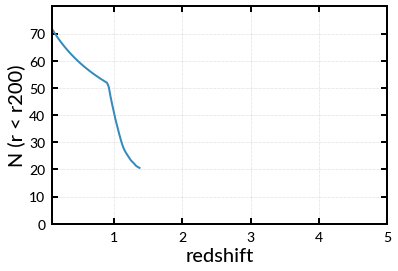

In [9]:
plt.figure()
plt.plot(zs, (LF * V200.value + 1) * fr)
ax = plt.gca()
ax.set_yticks(np.arange(0, 75, 10))
plt.xlim(0.1, 5)
plt.ylim(0, 80)
plt.xlabel('redshift')
plt.ylabel('N (r < r200)')
plt.grid()

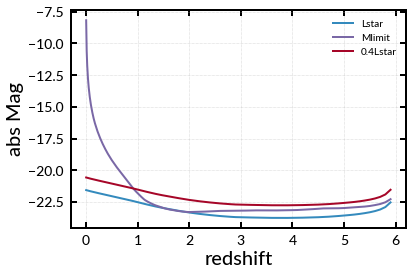

In [10]:
# calculate the abs mag of our limiting magnitude as a function of z
mlim = 23.5
#Mlim = model.get_absolute_mags(zf, filters='i', zs=zs) - 2.5 * np.log10(0.4)
Mlim = mlim - cosmo.distmod(zs).value - model.get_kcorrects(zf, filters='i', zs=zs)
plt.figure()
plt.plot(zs, model.get_absolute_mags(zf, filters='i', zs=zs), label='Lstar')
plt.plot(zs, Mlim, label='Mlimit')
plt.plot(zs, model.get_absolute_mags(zf, filters='i', zs=zs) - 2.5 * np.log10(0.4), label='0.4Lstar')
plt.grid()
plt.xlabel('redshift')
plt.ylabel('abs Mag')
plt.legend()

In [11]:
Mlim

array([ -8.1658134 ,  -9.68495902, -10.57712692, -11.21590893,
       -11.71317736, -12.12290307, -12.47160961, -12.77411805,
       -13.04159075, -13.28498939, -13.50334666, -13.7055737 ,
       -13.89190301, -14.06351244, -14.22556981, -14.37699888,
       -14.5193843 , -14.65682555, -14.78502903, -14.9069075 ,
       -15.45391931, -15.91286253, -16.29646466, -16.62851574,
       -16.93172572, -17.20374221, -17.45777789, -17.69273943,
       -17.91992918, -18.12987769, -18.32865681, -18.51828907,
       -18.69976994, -18.86891746, -19.03642649, -19.19397521,
       -19.34179258, -19.4892439 , -19.63047416, -19.77424126,
       -19.91108518, -20.03864248, -20.16951124, -20.29877324,
       -20.42751841, -20.55921112, -20.69559866, -20.83252436,
       -20.96665018, -21.09965252, -21.22894866, -21.35956163,
       -21.47795764, -21.59165994, -21.69933654, -21.80210694,
       -21.9075376 , -22.00622275, -22.10366806, -22.20027099,
       -22.29100864, -22.36640173, -22.42845094, -22.48

In [12]:
Mstar - 2.5 * np.log10(0.4) # 0.4L* magnitudes

array([-20.57008079, -20.57597325, -20.58179183, -20.5875379 ,
       -20.59315221, -20.59866339, -20.60410763, -20.60948613,
       -20.61491286, -20.62028775, -20.62559825, -20.63085243,
       -20.6361888 , -20.64146161, -20.64667197, -20.65183576,
       -20.65708687, -20.66227606, -20.66740441, -20.67247647,
       -20.69788217, -20.72276832, -20.74717636, -20.77114779,
       -20.79472324, -20.81792192, -20.84079074, -20.86338788,
       -20.88574247, -20.90787483, -20.92980046, -20.95167168,
       -20.97363203, -20.99554516, -21.01738616, -21.03918731,
       -21.06161016, -21.08403246, -21.10630224, -21.12975616,
       -21.1531245 , -21.17677915, -21.20122247, -21.2250567 ,
       -21.24963478, -21.27334722, -21.29763075, -21.32132178,
       -21.34592426, -21.36980908, -21.39509567, -21.4191294 ,
       -21.44521967, -21.47012112, -21.49621011, -21.52236259,
       -21.54762003, -21.57405979, -21.59920148, -21.62422419,
       -21.64926965, -21.67312985, -21.69756533, -21.72

In [13]:
np.array(LF) # LF integration output

array([2.56524068, 2.57496239, 2.58480829, 2.5947786 , 2.60487352,
       2.61509328, 2.62543812, 2.63590825, 2.64650394, 2.65722542,
       2.66807296, 2.6790468 , 2.69014722, 2.7013745 , 2.7127289 ,
       2.72421071, 2.73582023, 2.74755773, 2.75942353, 2.77141792,
       2.83332971, 2.89850436, 2.96698453, 3.03881509, 3.11404292,
       3.19271665, 3.27488652, 3.36060417, 3.44992249, 3.54289555,
       3.6395784 , 3.74002706, 3.84429835, 3.95244988, 4.06453993,
       4.18062741, 4.30077181, 4.42503314, 4.55347189, 4.68614897,
       4.82312573, 4.96446385, 5.11022536, 5.26047263, 5.41526828,
       5.57467524, 5.73875664, 5.90757588, 6.08119656, 6.25968247,
       6.4430976 , 6.6315061 , 6.67119425, 6.44094924, 6.23373234,
       6.04020869, 5.81921663, 5.62802277, 5.42776437, 5.22280248,
       5.04011196, 4.92332275, 4.87332859, 4.84631645, 4.81782225,
       4.78861725, 4.81229945, 4.82777386, 4.82171217, 4.88408009,
       4.95714151,        nan,        nan,        nan,        

In [14]:
alpha

array([-1.04651452, -1.04305782, -1.03962952, -1.03622926, -1.03285666,
       -1.02951137, -1.02619304, -1.02290132, -1.01963587, -1.01639636,
       -1.01318245, -1.00999383, -1.00683018, -1.00369119, -1.00057656,
       -0.99748597, -0.99441914, -0.99137577, -0.98835558, -0.98535829,
       -0.97070578, -0.95658611, -0.94296894, -0.92982625, -0.91713213,
       -0.90486257, -0.89299531, -0.88150964, -0.8703863 , -0.85960735,
       -0.84915603, -0.83901671, -0.82917473, -0.81961638, -0.81032882,
       -0.80129997, -0.79251849, -0.78397371, -0.77565559, -0.76755466,
       -0.75966198, -0.75196911, -0.7444681 , -0.73715138, -0.73001183,
       -0.72304268, -0.71623751, -0.70959023, -0.70309507, -0.69674653,
       -0.69053938, -0.68446866, -0.67852962, -0.67271776, -0.66702877,
       -0.66145855, -0.65600318, -0.65065893, -0.6454222 , -0.64028958,
       -0.6352578 , -0.63032373, -0.62548436, -0.62073683, -0.61607836,
       -0.61150633, -0.60701818, -0.60261149, -0.59828392, -0.59

In [15]:
phi_star

array([  3.61628424,   3.63273137,   3.6493422 ,   3.66611754,
         3.6830582 ,   3.70016499,   3.71743872,   3.73488021,
         3.75249026,   3.77026968,   3.78821929,   3.8063399 ,
         3.82463232,   3.84309735,   3.86173582,   3.88054852,
         3.89953628,   3.9186999 ,   3.9380402 ,   3.95755798,
         4.05783755,   4.16267589,   4.2721744 ,   4.38643445,
         4.50555743,   4.62964473,   4.75879774,   4.89311787,
         5.03270649,   5.17766503,   5.32809488,   5.48409745,
         5.64577414,   5.81322637,   5.98655557,   6.16586313,
         6.35125049,   6.54281907,   6.7406703 ,   6.9449056 ,
         7.15562641,   7.37293417,   7.5969303 ,   7.82771627,
         8.0653935 ,   8.31006345,   8.56182756,   8.82078729,
         9.08704409,   9.36069943,   9.64185476,   9.93061155,
        10.22707127,  10.53133538,  10.84350536,  11.16368269,
        11.49196884,  11.82846529,  12.17327353,  12.52649505,
        12.88823134,  13.25858389,  13.63765419,  14.02

In [16]:
fr # red fraction

array([0.79800747, 0.79602975, 0.79406667, 0.79211803, 0.79018368,
       0.78826342, 0.7863571 , 0.78446454, 0.78258558, 0.78072006,
       0.77886781, 0.77702869, 0.77520253, 0.77338919, 0.77158852,
       0.76980036, 0.76802458, 0.76626103, 0.76450957, 0.76277007,
       0.75424723, 0.74600385, 0.73802497, 0.73029674, 0.72280632,
       0.71554175, 0.70849191, 0.70164642, 0.69499559, 0.68853037,
       0.68224229, 0.6761234 , 0.67016625, 0.66436384, 0.65870958,
       0.65319726, 0.64782106, 0.64257546, 0.63745526, 0.63245553,
       0.62757163, 0.62279916, 0.61813393, 0.61357199, 0.60910959,
       0.60474316, 0.6004693 , 0.59628479, 0.59218657, 0.5881717 ,
       0.58423739, 0.580381  , 0.57659998, 0.5728919 , 0.56925445,
       0.56568542, 0.5621827 , 0.55874424, 0.55536811, 0.55205245,
       0.54879547, 0.54559547, 0.5424508 , 0.53935989, 0.53632122,
       0.53333333, 0.53039484, 0.52750438, 0.52466067, 0.52186246,
       0.51910855, 0.51639778, 0.51372904, 0.51110125, 0.50851

In [17]:
zs # redshift array

array([5.000e-03, 1.000e-02, 1.500e-02, 2.000e-02, 2.500e-02, 3.000e-02,
       3.500e-02, 4.000e-02, 4.500e-02, 5.000e-02, 5.500e-02, 6.000e-02,
       6.500e-02, 7.000e-02, 7.500e-02, 8.000e-02, 8.500e-02, 9.000e-02,
       9.500e-02, 1.000e-01, 1.250e-01, 1.500e-01, 1.750e-01, 2.000e-01,
       2.250e-01, 2.500e-01, 2.750e-01, 3.000e-01, 3.250e-01, 3.500e-01,
       3.750e-01, 4.000e-01, 4.250e-01, 4.500e-01, 4.750e-01, 5.000e-01,
       5.250e-01, 5.500e-01, 5.750e-01, 6.000e-01, 6.250e-01, 6.500e-01,
       6.750e-01, 7.000e-01, 7.250e-01, 7.500e-01, 7.750e-01, 8.000e-01,
       8.250e-01, 8.500e-01, 8.750e-01, 9.000e-01, 9.250e-01, 9.500e-01,
       9.750e-01, 1.000e+00, 1.025e+00, 1.050e+00, 1.075e+00, 1.100e+00,
       1.125e+00, 1.150e+00, 1.175e+00, 1.200e+00, 1.225e+00, 1.250e+00,
       1.275e+00, 1.300e+00, 1.325e+00, 1.350e+00, 1.375e+00, 1.400e+00,
       1.425e+00, 1.450e+00, 1.475e+00, 1.500e+00, 1.525e+00, 1.550e+00,
       1.575e+00, 1.600e+00, 1.625e+00, 1.650e+00, 

In [18]:
V200.value # cluster volume

array([36.6010513 , 36.43534065, 36.26949674, 36.10353559, 35.93747314,
       35.77132519, 35.60510745, 35.43883545, 35.27252465, 35.10619034,
       34.93984769, 34.7735117 , 34.60719727, 34.44091912, 34.27469183,
       34.10852982, 33.94244737, 33.77645859, 33.61057743, 33.44481766,
       32.61831051, 31.79680776, 30.98183566, 30.17480523, 29.37700988,
       28.58962465, 27.81370678, 27.05019758, 26.29992534, 25.56360913,
       24.84186338, 24.13520299, 23.44404891, 22.76873401, 22.10950915,
       21.46654933, 20.83995982, 20.22978224, 19.63600046, 19.05854632,
       18.49730512, 17.95212084, 17.42280102, 16.90912145, 16.41083043,
       15.92765277, 15.45929349, 15.0054412 , 14.56577119, 14.1399482 ,
       13.727629  , 13.32846465, 12.94210254, 12.5681882 , 12.20636691,
       11.85628513, 11.51759171, 11.189939  , 10.87298373, 10.56638784,
       10.26981915,  9.98295189,  9.70546717,  9.43705338,  9.17740644,
        8.92623004,  8.68323581,  8.4481434 ,  8.22068056,  8.00

In [7]:
200 * rho_crit(zs, cosmo)

<Quantity [2.73216196e+13, 2.74458803e+13, 2.75713779e+13, 2.76981183e+13,
           2.78261078e+13, 2.79553524e+13, 2.80858582e+13, 2.82176315e+13,
           2.83506783e+13, 2.84850048e+13, 2.86206170e+13, 2.87575212e+13,
           2.88957234e+13, 2.90352298e+13, 2.91760464e+13, 2.93181795e+13,
           2.94616351e+13, 2.96064194e+13, 2.97525385e+13, 2.98999986e+13,
           3.06576271e+13, 3.14496980e+13, 3.22769771e+13, 3.31402305e+13,
           3.40402241e+13, 3.49777240e+13, 3.59534962e+13, 3.69683067e+13,
           3.80229216e+13, 3.91181071e+13, 4.02546292e+13, 4.14332542e+13,
           4.26547481e+13, 4.39198771e+13, 4.52294075e+13, 4.65841056e+13,
           4.79847374e+13, 4.94320694e+13, 5.09268678e+13, 5.24698990e+13,
           5.40619292e+13, 5.57037249e+13, 5.73960524e+13, 5.91396781e+13,
           6.09353685e+13, 6.27838900e+13, 6.46860091e+13, 6.66424923e+13,
           6.86541061e+13, 7.07216169e+13, 7.28457915e+13, 7.50273963e+13,
           7.72671980e+13

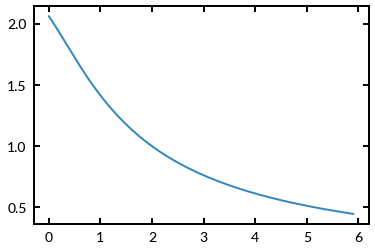

In [12]:
plt.plot(zs, (V200/(4/3 * np.pi))**(1/3))